## Problem Statement

**How can we aggregate the weather data of 5 cities in Spain to be used as representative weather data for power forecasting across the entire country?**

### The Challenge

The energy dataset contains electricity load data for **all of Spain**, while the weather dataset only contains measurements from **5 major cities**:
- Madrid
- Barcelona  
- Valencia
- Seville
- Bilbao

To use weather data for national power forecasting, we need to aggregate these 5 city measurements into a single representative value per timestamp.

## Justification for City-Based Aggregation

### Population Coverage Analysis

Before comparing aggregation methods, we must first justify whether aggregating data from these 5 cities is a reasonable approach for representing Spain's weather conditions.

| City | Metropolitan Population (ESPON 2018) | % of Spain |
|------|--------------------------------------|------------|
| Madrid | 6,155,116 | 12.67% |
| Barcelona | 5,179,243 | 10.66% |
| Valencia | 1,645,342 | 3.39% |
| Seville | 1,305,342 | 2.69% |
| Bilbao | 987,000 | 2.03% |
| **Total** | **15,272,043** | **31.43%** |

**Spain's Total Population:** 48,590,000

### Key Justifications

1. **Population Representation (~31%)**: The 5 metropolitan areas represent approximately 31% of Spain's total population. These are the **largest urban centers** where electricity consumption is concentrated.

2. **Geographic Diversity**: The cities span different climate zones:
   - **Madrid**: Central plateau (continental climate)
   - **Barcelona**: Mediterranean coast (Mediterranean climate)
   - **Valencia**: Eastern coast (Mediterranean climate)
   - **Seville**: Southern region (hot Mediterranean climate)
   - **Bilbao**: Northern coast (oceanic climate)

3. **Economic Activity**: Major cities account for a disproportionately large share of electricity consumption due to:
   - Industrial activity
   - Commercial buildings
   - Dense residential areas
   - Transportation infrastructure

4. **Weather Sensitivity**: Urban areas with high population density show stronger correlation between weather and electricity demand (heating/cooling loads).

### Limitations

- Rural and smaller urban areas are not directly represented
- Regional variations in weather patterns may not be fully captured
- Industrial regions outside major cities are underrepresented

Despite these limitations, using the 5 major cities provides a **practical and defensible approach** for national weather aggregation in power forecasting.

In [13]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import required libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# Import our pipeline
from data_pipeline import (
    DataWranglingPipeline, 
    get_aggregation_justification,
    CITY_POPULATIONS,
    SPAIN_POPULATION,
    COMBINED_CITY_POPULATION,
    COMBINED_CITY_PROPORTION
)

print("Libraries imported successfully!")

c:\Users\rami0\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


In [2]:
# Download and load the dataset
path = kagglehub.dataset_download(handle="nicholasjhana/energy-consumption-generation-prices-and-weather")
print("Path to dataset files:", path)

path_energy = path + "/energy_dataset.csv"
path_weather = path + "/weather_features.csv"

Path to dataset files: C:\Users\rami0\.cache\kagglehub\datasets\nicholasjhana\energy-consumption-generation-prices-and-weather\versions\1


## Population Coverage Visualization

AGGREGATION JUSTIFICATION: Population Coverage

Spain's Total Population: 48,590,000
Combined 5-City Population: 15,272,043
Coverage Percentage: 31.43%

City Breakdown:
  Madrid: 6,155,116 (12.67%)
  Barcelona: 5,179,243 (10.66%)
  Valencia: 1,645,342 (3.39%)
  Seville: 1,305,342 (2.69%)
  Bilbao: 987,000 (2.03%)


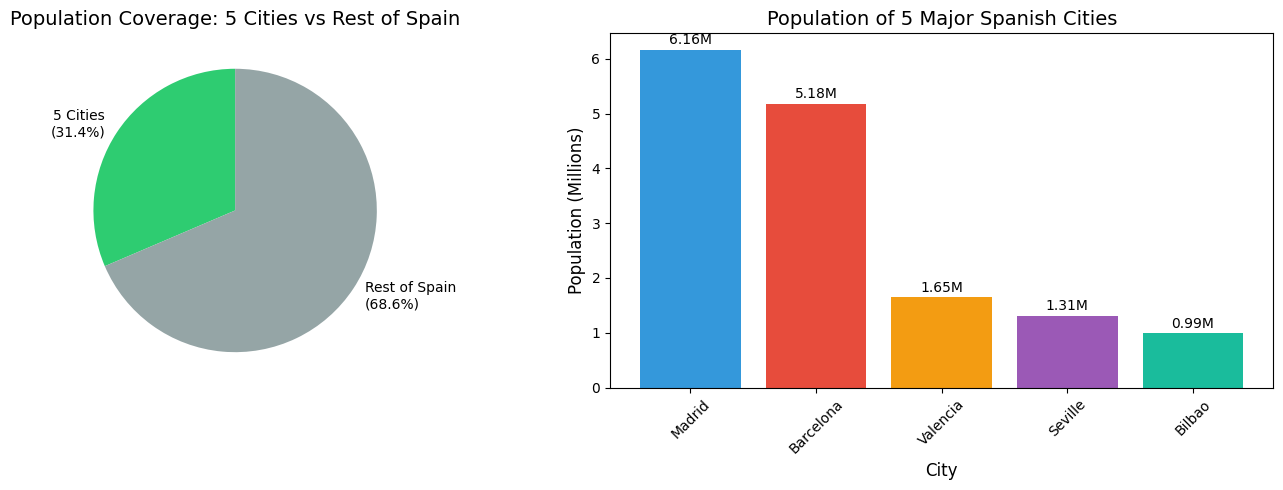

In [ ]:
# Visualize population coverage
justification = get_aggregation_justification()

print(f"\nSpain's Total Population: {SPAIN_POPULATION:,}")
print(f"Combined 5-City Population: {COMBINED_CITY_POPULATION:,}")
print(f"Coverage Percentage: {COMBINED_CITY_PROPORTION * 100:.2f}%")
print("\nCity Breakdown:")
for city, pop in CITY_POPULATIONS.items():
    pct = (pop / SPAIN_POPULATION) * 100
    print(f"  {city}: {pop:,} ({pct:.2f}%)")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart: Coverage
ax1 = axes[0]
sizes = [COMBINED_CITY_POPULATION, SPAIN_POPULATION - COMBINED_CITY_POPULATION]
labels = [f'5 Cities\n({COMBINED_CITY_PROPORTION*100:.1f}%)', f'Rest of Spain\n({(1-COMBINED_CITY_PROPORTION)*100:.1f}%)']
colors = ['#2ecc71', '#95a5a6']
ax1.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
ax1.set_title('Population Coverage: 5 Cities vs Rest of Spain', fontsize=14)

# Bar chart: City populations
ax2 = axes[1]
cities = list(CITY_POPULATIONS.keys())
pops = [CITY_POPULATIONS[c] / 1e6 for c in cities]
bars = ax2.bar(cities, pops, color=['#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c'])
ax2.set_ylabel('Population (Millions)', fontsize=12)
ax2.set_xlabel('City', fontsize=12)
ax2.set_title('Population of 5 Major Spanish Cities', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, pop in zip(bars, pops):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{pop:.2f}M', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Aggregation Methods Overview

We compare three aggregation methods for combining weather data from 5 cities:

### 1. Huber M-Estimator Mean
A robust statistical estimator that combines the efficiency of the arithmetic mean with the robustness of the median. The Huber loss function is:

$$L_\delta(a) = \begin{cases} \frac{1}{2}a^2 & \text{for } |a| \leq \delta \\ \delta(|a| - \frac{1}{2}\delta) & \text{otherwise} \end{cases}$$

**Advantages**: Robust to outliers while maintaining statistical efficiency.

### 2. Trimmed Mean
Removes extreme values before calculating the mean. With 5 cities and 20% trimming from each end, this effectively removes the highest and lowest values, averaging the remaining 3.

**Advantages**: Simple, interpretable, and robust to extreme regional variations.

### 3. Population-Weighted Mean
Weights each city's weather measurement by its population proportion:

$$\bar{x}_{weighted} = \frac{\sum_{i=1}^{n} w_i \cdot x_i}{\sum_{i=1}^{n} w_i}$$

where $w_i$ is the population proportion of city $i$.

**Advantages**: Gives more weight to cities with larger populations (and likely higher energy consumption).

In [ ]:
print("Available Aggregation Methods:")
print("=" * 50)
for method in DataWranglingPipeline.get_available_methods():
    desc = DataWranglingPipeline.get_method_description(method)
    print(f"\n• {method}:")
    print(f"  {desc}")

Available Aggregation Methods:

• huber:
  Huber M-estimator - robust to outliers, combines efficiency of mean with robustness of median

• trimmed:
  Trimmed Mean - removes extreme values (20% from each end) before averaging

• population_weighted:
  Population-Weighted Mean - weights each city by its population proportion

• mean:
  Arithmetic Mean - simple average (baseline)

• median:
  Median - middle value, robust to outliers


## Run Pipelines with Different Aggregation Methods

In [5]:
# Define the aggregation methods to compare
methods_to_compare = ['huber', 'trimmed', 'population_weighted']

# Store results
pipeline_results = {}

# Run each pipeline
for method in methods_to_compare:
    print(f"\n{'#' * 70}")
    print(f"Running pipeline with: {method.upper()}")
    print(f"{'#' * 70}\n")
    
    pipeline = DataWranglingPipeline(
        aggregation_method=method,
        create_lag_features=True,
        create_rolling_features=True,
        lag_periods=[1, 24, 168],
        rolling_windows=[24, 168]
    )
    
    result = pipeline.run(path_energy, path_weather)
    pipeline_results[method] = result
    
print("\n" + "=" * 70)
print("All pipelines completed!")
print("=" * 70)


######################################################################
Running pipeline with: HUBER
######################################################################

DATA WRANGLING PIPELINE
Aggregation Method: huber
Lag Features: enabled
Rolling Features: enabled
Step 1: Loading data...
  Energy data: (35064, 29)
  Weather data: (178396, 17)
Step 2: Cleaning data...
  Missing values in 'total load actual': 0
Step 2b: Checking timestamp alignment...
  --- Timestamp alignment per city ---
  ✓ Valencia: 35064 matching, 0 missing in weather, 0 extra in weather (100.0% coverage)
  ✓ Madrid: 35064 matching, 0 missing in weather, 0 extra in weather (100.0% coverage)
  ✓ Bilbao: 35064 matching, 0 missing in weather, 0 extra in weather (100.0% coverage)
  ✓ Barcelona: 35064 matching, 0 missing in weather, 0 extra in weather (100.0% coverage)
  ✓ Seville: 35064 matching, 0 missing in weather, 0 extra in weather (100.0% coverage)
  All timestamps aligned!
Step 3: Aggregating weather data u

In [6]:
# Compare dataset statistics
print("\nDataset Statistics by Aggregation Method:")
print("=" * 60)

stats_comparison = []
for method, df in pipeline_results.items():
    stats_comparison.append({
        'Method': method,
        'Rows': len(df),
        'Temp Mean (K)': df['temp'].mean(),
        'Temp Std (K)': df['temp'].std(),
        'Load Mean (MW)': df['total load actual'].mean(),
        'Load Std (MW)': df['total load actual'].std()
    })

stats_df = pd.DataFrame(stats_comparison)
print(stats_df.to_string(index=False))


Dataset Statistics by Aggregation Method:
             Method  Rows  Temp Mean (K)  Temp Std (K)  Load Mean (MW)  Load Std (MW)
              huber 34896     289.738530      7.258831    28708.346028    4575.117462
            trimmed 34896     289.718162      7.334300    28708.346028    4575.117462
population_weighted 34896     289.414169      7.649927    28708.346028    4575.117462


## Forecasting Model Comparison

We use a simple OLS regression model to compare how well each aggregation method supports power load forecasting.

In [7]:
def prepare_forecast_data(df, target_col='total load actual', feature_cols=None):
    """
    Prepare data for forecasting.
    """
    if feature_cols is None:
        feature_cols = ['temp', 'humidity', 'pressure', 'wind_speed',
                        'temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h',
                        'temp_rolling_mean_24h', 'temp_rolling_mean_168h']
    
    feature_cols = [col for col in feature_cols if col in df.columns]
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[mask]
    y = y[mask]
    
    return X, y, feature_cols


def train_ols_model(X_train, y_train, X_test, y_test):
    """
    Train OLS model and return metrics.
    """
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    
    model = sm.OLS(y_train, X_train_const).fit()
    
    y_pred_train = model.predict(X_train_const)
    y_pred_test = model.predict(X_test_const)
    
    metrics = {
        'R2_train': r2_score(y_train, y_pred_train),
        'R2_test': r2_score(y_test, y_pred_test),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE_train': mean_absolute_error(y_train, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test),
        'AIC': model.aic,
        'BIC': model.bic
    }
    
    return model, metrics, y_pred_test

print("Forecasting functions defined.")

Forecasting functions defined.


In [8]:
# Train and compare models for each aggregation method
forecast_results = {}

for method, result_df in pipeline_results.items():
    print(f"\n{'='*60}")
    print(f"Training OLS model: {method.upper()}")
    print(f"{'='*60}")
    
    # Prepare data
    X, y, used_features = prepare_forecast_data(result_df)
    print(f"Features: {used_features}")
    print(f"Sample size: {len(X)}")
    
    # Train/test split (80/20, preserving time order)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"Train: {len(X_train)}, Test: {len(X_test)}")
    
    # Train model
    model, metrics, y_pred = train_ols_model(X_train, y_train, X_test, y_test)
    
    forecast_results[method] = {
        'model': model,
        'metrics': metrics,
        'y_test': y_test,
        'y_pred': y_pred
    }
    
    print(f"\nResults:")
    print(f"  R² (test): {metrics['R2_test']:.4f}")
    print(f"  RMSE (test): {metrics['RMSE_test']:.2f} MW")
    print(f"  MAE (test): {metrics['MAE_test']:.2f} MW")


Training OLS model: HUBER
Features: ['temp', 'humidity', 'pressure', 'wind_speed', 'temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h', 'temp_rolling_mean_24h', 'temp_rolling_mean_168h']
Sample size: 34896
Train: 27916, Test: 6980

Results:
  R² (test): 0.2577
  RMSE (test): 3893.15 MW
  MAE (test): 3222.69 MW

Training OLS model: TRIMMED
Features: ['temp', 'humidity', 'pressure', 'wind_speed', 'temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h', 'temp_rolling_mean_24h', 'temp_rolling_mean_168h']
Sample size: 34896
Train: 27916, Test: 6980

Results:
  R² (test): 0.2701
  RMSE (test): 3860.47 MW
  MAE (test): 3191.95 MW

Training OLS model: POPULATION_WEIGHTED
Features: ['temp', 'humidity', 'pressure', 'wind_speed', 'temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h', 'temp_rolling_mean_24h', 'temp_rolling_mean_168h']
Sample size: 34896
Train: 27916, Test: 6980

Results:
  R² (test): 0.2775
  RMSE (test): 3840.88 MW
  MAE (test): 3173.93 MW


In [9]:
# Create comparison summary table
print("\n" + "=" * 80)
print("AGGREGATION METHOD COMPARISON - FORECASTING PERFORMANCE")
print("=" * 80)

comparison_table = pd.DataFrame({
    method: {
        'R² (test)': data['metrics']['R2_test'],
        'RMSE (test) [MW]': data['metrics']['RMSE_test'],
        'MAE (test) [MW]': data['metrics']['MAE_test'],
        'AIC': data['metrics']['AIC'],
        'BIC': data['metrics']['BIC']
    }
    for method, data in forecast_results.items()
}).T

print("\nMetrics Summary:")
print(comparison_table.to_string())

# Identify best method for each metric
print("\n" + "-" * 50)
print("Best Method by Metric:")
print("-" * 50)
print(f"  Highest R²:   {comparison_table['R² (test)'].idxmax()} ({comparison_table['R² (test)'].max():.4f})")
print(f"  Lowest RMSE:  {comparison_table['RMSE (test) [MW]'].idxmin()} ({comparison_table['RMSE (test) [MW]'].min():.2f} MW)")
print(f"  Lowest MAE:   {comparison_table['MAE (test) [MW]'].idxmin()} ({comparison_table['MAE (test) [MW]'].min():.2f} MW)")
print(f"  Lowest AIC:   {comparison_table['AIC'].idxmin()} ({comparison_table['AIC'].min():.2f})")
print(f"  Lowest BIC:   {comparison_table['BIC'].idxmin()} ({comparison_table['BIC'].min():.2f})")


AGGREGATION METHOD COMPARISON - FORECASTING PERFORMANCE

Metrics Summary:
                     R² (test)  RMSE (test) [MW]  MAE (test) [MW]            AIC            BIC
huber                 0.257682       3893.146862      3222.689463  542460.695956  542543.065509
trimmed               0.270091       3860.470871      3191.946866  541953.075018  542035.444571
population_weighted   0.277481       3840.877942      3173.930097  541842.981166  541925.350719

--------------------------------------------------
Best Method by Metric:
--------------------------------------------------
  Highest R²:   population_weighted (0.2775)
  Lowest RMSE:  population_weighted (3840.88 MW)
  Lowest MAE:   population_weighted (3173.93 MW)
  Lowest AIC:   population_weighted (541842.98)
  Lowest BIC:   population_weighted (541925.35)


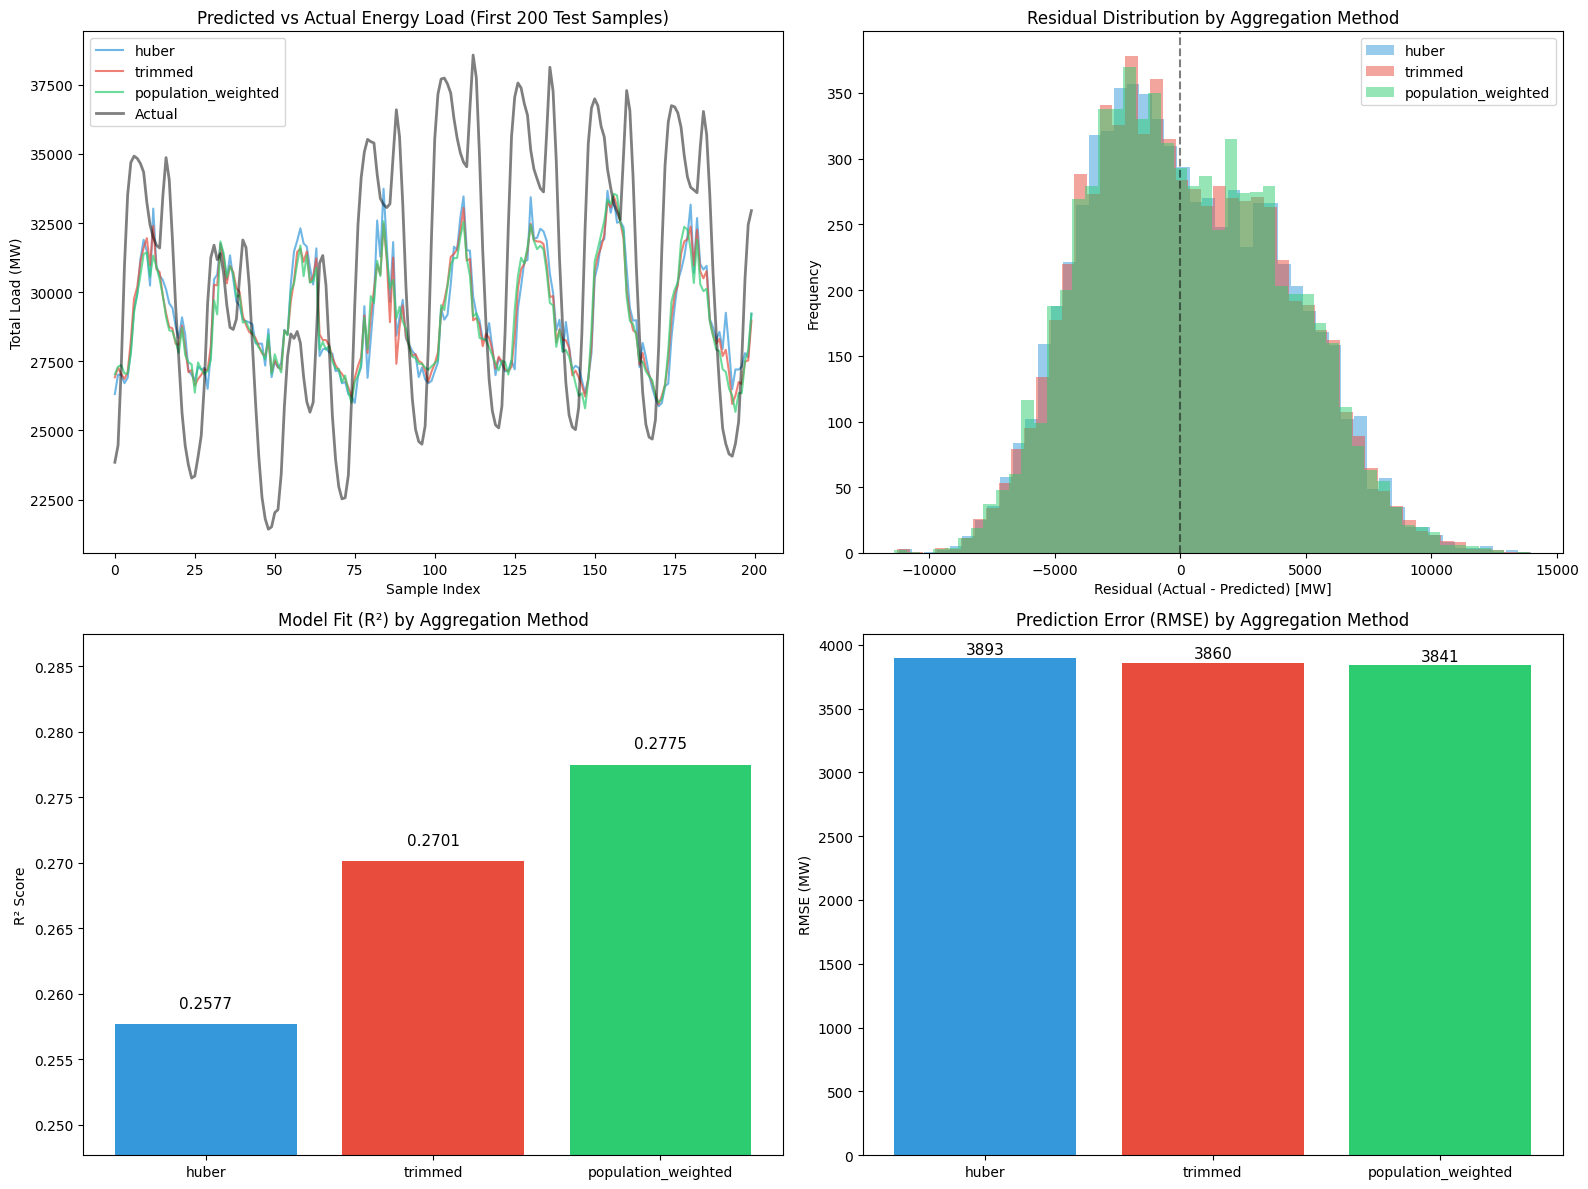

In [10]:
# Visualize forecasting comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = {'huber': '#3498db', 'trimmed': '#e74c3c', 'population_weighted': '#2ecc71'}

# Plot 1: Actual vs Predicted (sample)
ax1 = axes[0, 0]
sample_size = 200
for method, color in colors.items():
    y_pred = forecast_results[method]['y_pred'].iloc[:sample_size]
    ax1.plot(range(sample_size), y_pred, label=f'{method}', alpha=0.7, color=color)
y_actual = forecast_results['huber']['y_test'].iloc[:sample_size]
ax1.plot(range(sample_size), y_actual.values, label='Actual', color='black', linewidth=2, alpha=0.5)
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Total Load (MW)')
ax1.set_title('Predicted vs Actual Energy Load (First 200 Test Samples)')
ax1.legend()

# Plot 2: Residuals distribution
ax2 = axes[0, 1]
for method, color in colors.items():
    residuals = forecast_results[method]['y_test'].values - forecast_results[method]['y_pred'].values
    ax2.hist(residuals, bins=50, alpha=0.5, label=f'{method}', color=color)
ax2.set_xlabel('Residual (Actual - Predicted) [MW]')
ax2.set_ylabel('Frequency')
ax2.set_title('Residual Distribution by Aggregation Method')
ax2.legend()
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Plot 3: Bar chart of R²
ax3 = axes[1, 0]
methods = list(colors.keys())
r2_values = [forecast_results[m]['metrics']['R2_test'] for m in methods]
bars = ax3.bar(methods, r2_values, color=[colors[m] for m in methods])
ax3.set_ylabel('R² Score')
ax3.set_title('Model Fit (R²) by Aggregation Method')
ax3.set_ylim([min(r2_values) - 0.01, max(r2_values) + 0.01])
for bar, val in zip(bars, r2_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11)

# Plot 4: Bar chart of RMSE
ax4 = axes[1, 1]
rmse_values = [forecast_results[m]['metrics']['RMSE_test'] for m in methods]
bars = ax4.bar(methods, rmse_values, color=[colors[m] for m in methods])
ax4.set_ylabel('RMSE (MW)')
ax4.set_title('Prediction Error (RMSE) by Aggregation Method')
for bar, val in zip(bars, rmse_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{val:.0f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## Temperature Aggregation Comparison

Let's visualize how the different aggregation methods affect the temperature values.

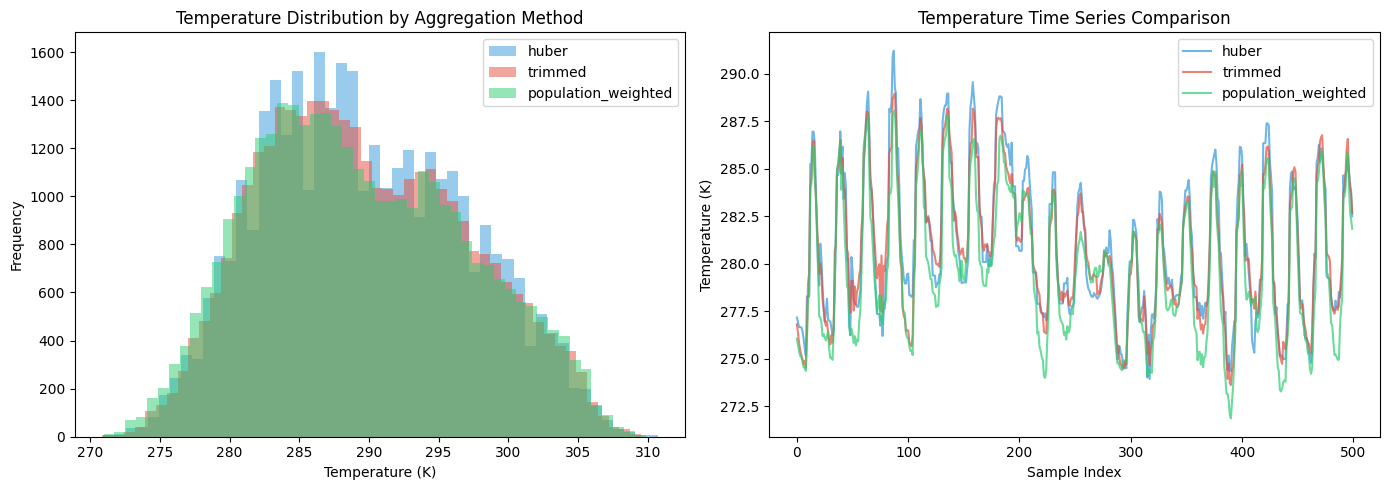


Temperature Statistics by Aggregation Method:

HUBER:
  Mean: 289.74 K
  Std:  7.26 K
  Min:  270.95 K
  Max:  310.71 K

TRIMMED:
  Mean: 289.72 K
  Std:  7.33 K
  Min:  270.87 K
  Max:  309.52 K

POPULATION_WEIGHTED:
  Mean: 289.41 K
  Std:  7.65 K
  Min:  270.97 K
  Max:  309.86 K


In [11]:
# Compare temperature distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Temperature distribution
ax1 = axes[0]
for method, color in colors.items():
    temp_data = pipeline_results[method]['temp']
    ax1.hist(temp_data, bins=50, alpha=0.5, label=method, color=color)
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Frequency')
ax1.set_title('Temperature Distribution by Aggregation Method')
ax1.legend()

# Plot 2: Temperature time series (first 500 points)
ax2 = axes[1]
sample_size = 500
for method, color in colors.items():
    temp_data = pipeline_results[method]['temp'].iloc[:sample_size]
    ax2.plot(range(sample_size), temp_data.values, label=method, alpha=0.7, color=color)
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('Temperature Time Series Comparison')
ax2.legend()

plt.tight_layout()
plt.show()

# Temperature statistics
print("\nTemperature Statistics by Aggregation Method:")
print("=" * 50)
for method in methods_to_compare:
    temp = pipeline_results[method]['temp']
    print(f"\n{method.upper()}:")
    print(f"  Mean: {temp.mean():.2f} K")
    print(f"  Std:  {temp.std():.2f} K")
    print(f"  Min:  {temp.min():.2f} K")
    print(f"  Max:  {temp.max():.2f} K")

In [12]:
# Save the best performing dataset
best_method = comparison_table['R² (test)'].idxmax()
output_path = f"data_pipeline_output_final/processed_energy_weather_{best_method}.csv"

import os
os.makedirs('data_pipeline_output_final', exist_ok=True)

pipeline_results[best_method].to_csv(output_path)
print(f"Best performing dataset ({best_method}) saved to: {output_path}")
print(f"\nFinal dataset shape: {pipeline_results[best_method].shape}")

Best performing dataset (population_weighted) saved to: data_pipeline_output_final/processed_energy_weather_population_weighted.csv

Final dataset shape: (34896, 57)
